<a href="https://colab.research.google.com/github/timeseriesAI/tsai/blob/master/tutorial_nbs/01_Intro_to_Time_Series_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

created by Ignacio Oguiza - email: oguiza@timeseriesAI.co

## Purpose 😇

The purpose of this notebook is to show you how you can create a simple, end-to-end, state-of-the-art time series classification model using the great **fastai-v2** library in 5 steps:
1. Import libraries
2. Prepare data
3. Build learner
4. Train model
5. Inference (predictions) on additional data

In general, there are 3 main ways to classify time series, based on the input to the neural network:

- raw data

- image data (encoded from raw data)

- feature data (extracted from raw data)

In this notebook, we will use the first approach.

## Import libraries 📚

In [41]:
# # **************** UNCOMMENT AND RUN THIS CELL IF YOU NEED TO INSTALL/ UPGRADE TSAI ****************
stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null

In [6]:
from tsai.all import *
import sklearn.metrics as skm
my_setup()

os              : Linux-6.1.85+-x86_64-with-glibc2.35
python          : 3.11.11
tsai            : 0.3.9
fastai          : 2.7.18
fastcore        : 1.7.28
torch           : 2.2.2+cu121
device          : cpu
cpu cores       : 1
threads per cpu : 2
RAM             : 12.67 GB
GPU memory      : N/A


## Prepare data 🔢

### Download data ⬇️

In this notebook, we'll use one of the most widely used time series classification databases: UEA & UCR Time Series Classification Repository. As of Sep 2019 it contains 128 univariate datasets and 30 multivariate datasets.


In [ ]:
print(get_UCR_univariate_list())

['ACSF1', 'Adiac', 'AllGestureWiimoteX', 'AllGestureWiimoteY', 'AllGestureWiimoteZ', 'ArrowHead', 'Beef', 'BeetleFly', 'BirdChicken', 'BME', 'Car', 'CBF', 'Chinatown', 'ChlorineConcentration', 'CinCECGTorso', 'Coffee', 'Computers', 'CricketX', 'CricketY', 'CricketZ', 'Crop', 'DiatomSizeReduction', 'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxOutlineCorrect', 'DistalPhalanxTW', 'DodgerLoopDay', 'DodgerLoopGame', 'DodgerLoopWeekend', 'Earthquakes', 'ECG200', 'ECG5000', 'ECGFiveDays', 'ElectricDevices', 'EOGHorizontalSignal', 'EOGVerticalSignal', 'EthanolLevel', 'FaceAll', 'FaceFour', 'FacesUCR', 'FiftyWords', 'Fish', 'FordA', 'FordB', 'FreezerRegularTrain', 'FreezerSmallTrain', 'Fungi', 'GestureMidAirD1', 'GestureMidAirD2', 'GestureMidAirD3', 'GesturePebbleZ1', 'GesturePebbleZ2', 'GunPoint', 'GunPointAgeSpan', 'GunPointMaleVersusFemale', 'GunPointOldVersusYoung', 'Ham', 'HandOutlines', 'Haptics', 'Herring', 'HouseTwenty', 'InlineSkate', 'InsectEPGRegularTrain', 'InsectEPGSmallTrain', 'I

In [ ]:
print(get_UCR_multivariate_list())

['ArticularyWordRecognition', 'AtrialFibrillation', 'BasicMotions', 'CharacterTrajectories', 'Cricket', 'DuckDuckGeese', 'EigenWorms', 'Epilepsy', 'ERing', 'EthanolConcentration', 'FaceDetection', 'FingerMovements', 'HandMovementDirection', 'Handwriting', 'Heartbeat', 'InsectWingbeat', 'JapaneseVowels', 'Libras', 'LSST', 'MotorImagery', 'NATOPS', 'PEMS-SF', 'PenDigits', 'PhonemeSpectra', 'RacketSports', 'SelfRegulationSCP1', 'SelfRegulationSCP2', 'SpokenArabicDigits', 'StandWalkJump', 'UWaveGestureLibrary']


In the case of UCR data it's very easy to get data loaded. Let's select a dataset. You can modify this and select any one from the previous lists (univariate of multivariate).

`return_split` determines whether the UCR data will be returned already split between train and test or not.

In [7]:
# dataset id
dsid = 'ElectricDevices'
X, y, splits = get_UCR_data(dsid, return_split=False)
X.shape, y.shape, splits

((16637, 1, 96),
 (16637,),
 ((#8926) [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19...],
  (#7711) [8926,8927,8928,8929,8930,8931,8932,8933,8934,8935,8936,8937,8938,8939,8940,8941,8942,8943,8944,8945...]))

☣️ **Something very important when you prepare your own data is that data needs to be in a 3-d array with the following format:**

1. Samples
2. Variables
3. Length (aka time or sequence steps)

Variables = 1 for univariate datasets and >1 for multivariate.

In the case your data is already separate between train and test like this:

In [8]:
X_train, y_train, X_test, y_test  = get_UCR_data(dsid, return_split=True)

you can use this convenience function to get X, y and splits:

In [9]:
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

All UEA & UCR Time Series Classification data have already been split between train and valid. When you use your own data, you'll have to split it yourself. We'll see examples of this in future notebooks.

### Prepare datasets 💿

The first step is to create datasets. This is very easy to do in v2.

In TS classification problems, you will usually want to use an item tfm to transform y into categories.

We'll use `inplace=True` to preprocess data at dataset initialization. This will significantly speed up training.

In [10]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

We'll now build the `DataLoader`s (dls) that will create batches of data.

You will need to pass:

* datasets: usually 2 - train and valid -  or 1 - test or unlabelled- depending on the problem
* batch size(s): you may pass a single value (will be applied to all dls, or different values, one for each dl.
* batch_tfms (same as after_batch): you may decide to pass some tfms at the batch level. In this case for example, we'll standardize the data (0 mean and 1 std). You may get more details on how these transforms work in the transforms nb.
* num workers: num_workers > 0 is used to preprocess batches of data so that the next batch is ready for use when the current batch has been finished. More num_workers would consume more memory usage but is helpful to speed up the I/O process. This will depend on your machine, dataset, etc. You may want to start with 0, and test other values to see how to train faster. For me, 0 works better.

In [11]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)

### Visualize data

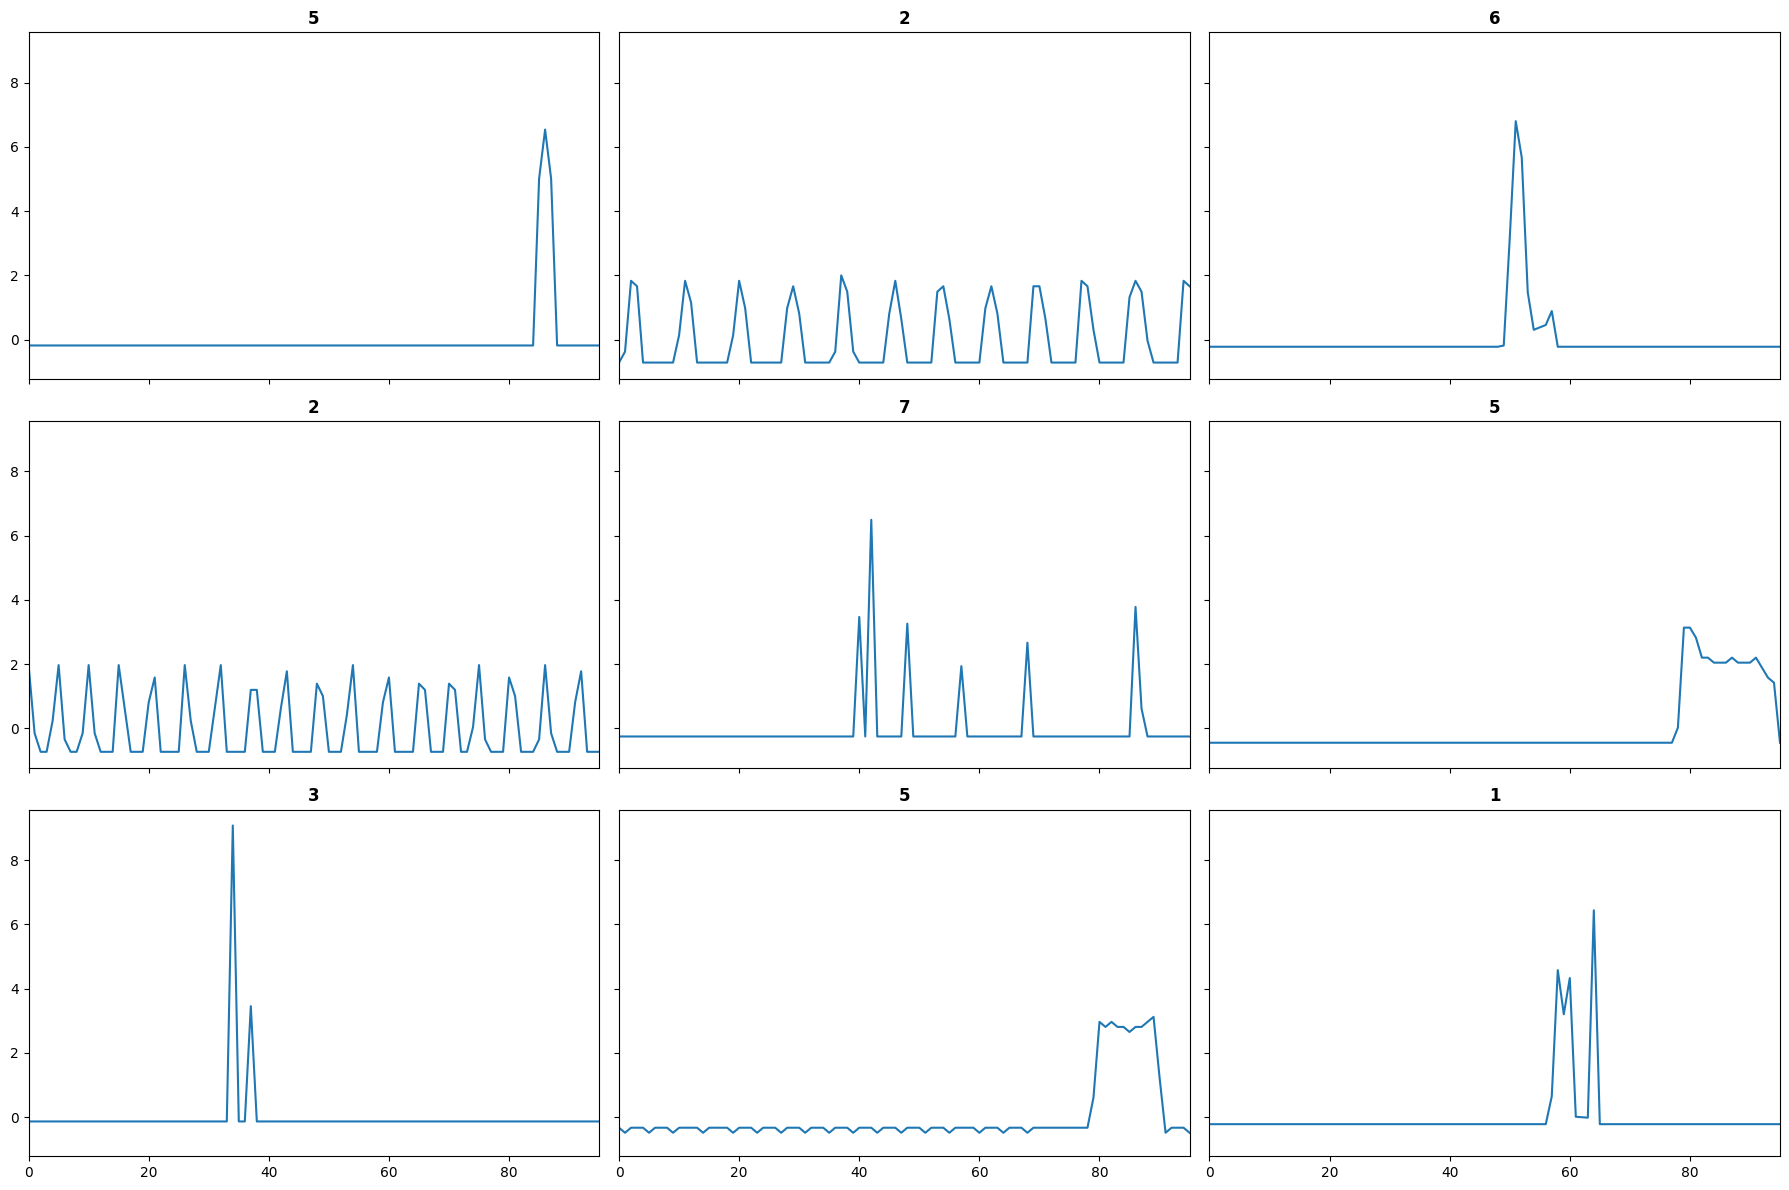

In [39]:
dls.show_batch(sharey=True)

## Build learner 🏗

In [25]:

c_in= dls.vars
c_out= dls.c
layers=[128, 256, 128] # les couches cachées
kss=[7, 5, 3] # the core sizes for the layer c'est un nombre impaire
model = FCN(c_in,c_out, layers, kss)
learn = Learner(dls, model, metrics=accuracy)  # creat and train our model
learn.save('stage0')

Path('models/stage0.pth')

## Train model 🚵🏼‍

### LR find 🔎

SuggestedLRs(valley=0.0030199517495930195)

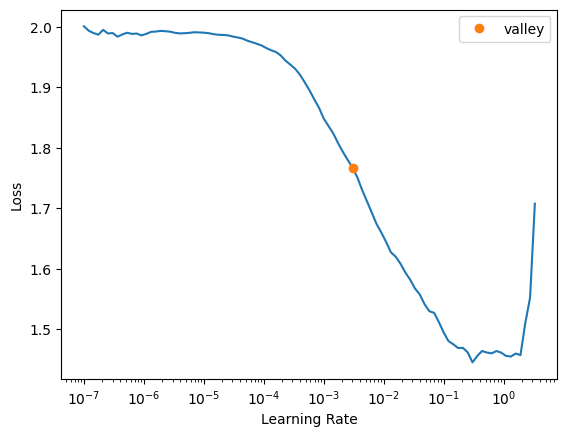

In [26]:
learn.load('stage0')
learn.lr_find()

### Train 🏃🏽‍♀️

In [45]:
learn.fit_one_cycle(5, lr_max=1e-3)
learn.save('stage1')

epoch,train_loss,valid_loss,accuracy,time
0,1.213793,1.465016,0.465828,00:49
1,1.211385,1.460040,0.467644,00:47
2,1.208233,1.446317,0.469459,00:48
3,1.209879,1.455238,0.469719,00:50
4,1.196277,1.449648,0.470237,00:50


Path('export/stage1.pth')

In [46]:
learn.recorder.plot_metrics()

AttributeError: 'FCN' object has no attribute 'values'

Let's pretend we need to end the working session now for some reason, but we'd like to continue working with this datasets and learner in the future.

To save everything you can use a convenience function I've created that saves the learner with the model, the data and the opt function status:

In [30]:
learn.save_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')

As soon as we've done this, we can end the session, and continue at any time in the future.

Let's simulate that we need to end the session now:

In [32]:
del learn, dsets, dls

Next time we go back to work, we'll need to reload the datasets and learner (with the same status we had):

In [33]:
learn = load_learner_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')
dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
b

(TSTensor(samples:128, vars:1, len:96, device=cpu, dtype=torch.float32),
 TensorCategory([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4,
                 4, 4]))

In [34]:
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
valid_probas, valid_targets, valid_preds

(tensor([[3.2168e-02, 5.2440e-04, 2.7785e-02,  ..., 5.3668e-03, 6.9255e-01,
          4.2017e-02],
         [2.2318e-02, 2.0713e-03, 1.3845e-02,  ..., 5.4838e-02, 1.5591e-01,
          3.9940e-02],
         [1.7935e-01, 9.8972e-04, 2.1373e-02,  ..., 1.2705e-02, 5.2694e-01,
          2.0241e-02],
         ...,
         [1.9471e-02, 3.6056e-03, 5.4421e-01,  ..., 1.2873e-01, 3.5730e-02,
          9.4706e-02],
         [7.5938e-02, 2.9408e-03, 5.0263e-02,  ..., 5.2247e-02, 1.7805e-01,
          2.9360e-02],
         [1.8491e-02, 3.5726e-03, 5.4568e-01,  ..., 1.2818e-01, 3.5027e-02,
          9.3985e-02]]),
 tensor([5, 5, 5,  ..., 3, 3, 3]),
 tensor([5, 3, 5,  ..., 2, 3, 2]))

We can confirm the learner has the same status it had at the end of training, by confirming the validation accuracy is the same:

In [35]:
(valid_targets == valid_preds).float().mean()

tensor(0.6497)

Great! It's the same. This means we have now the learner at the same point where we left it.

## Visualize results 👁

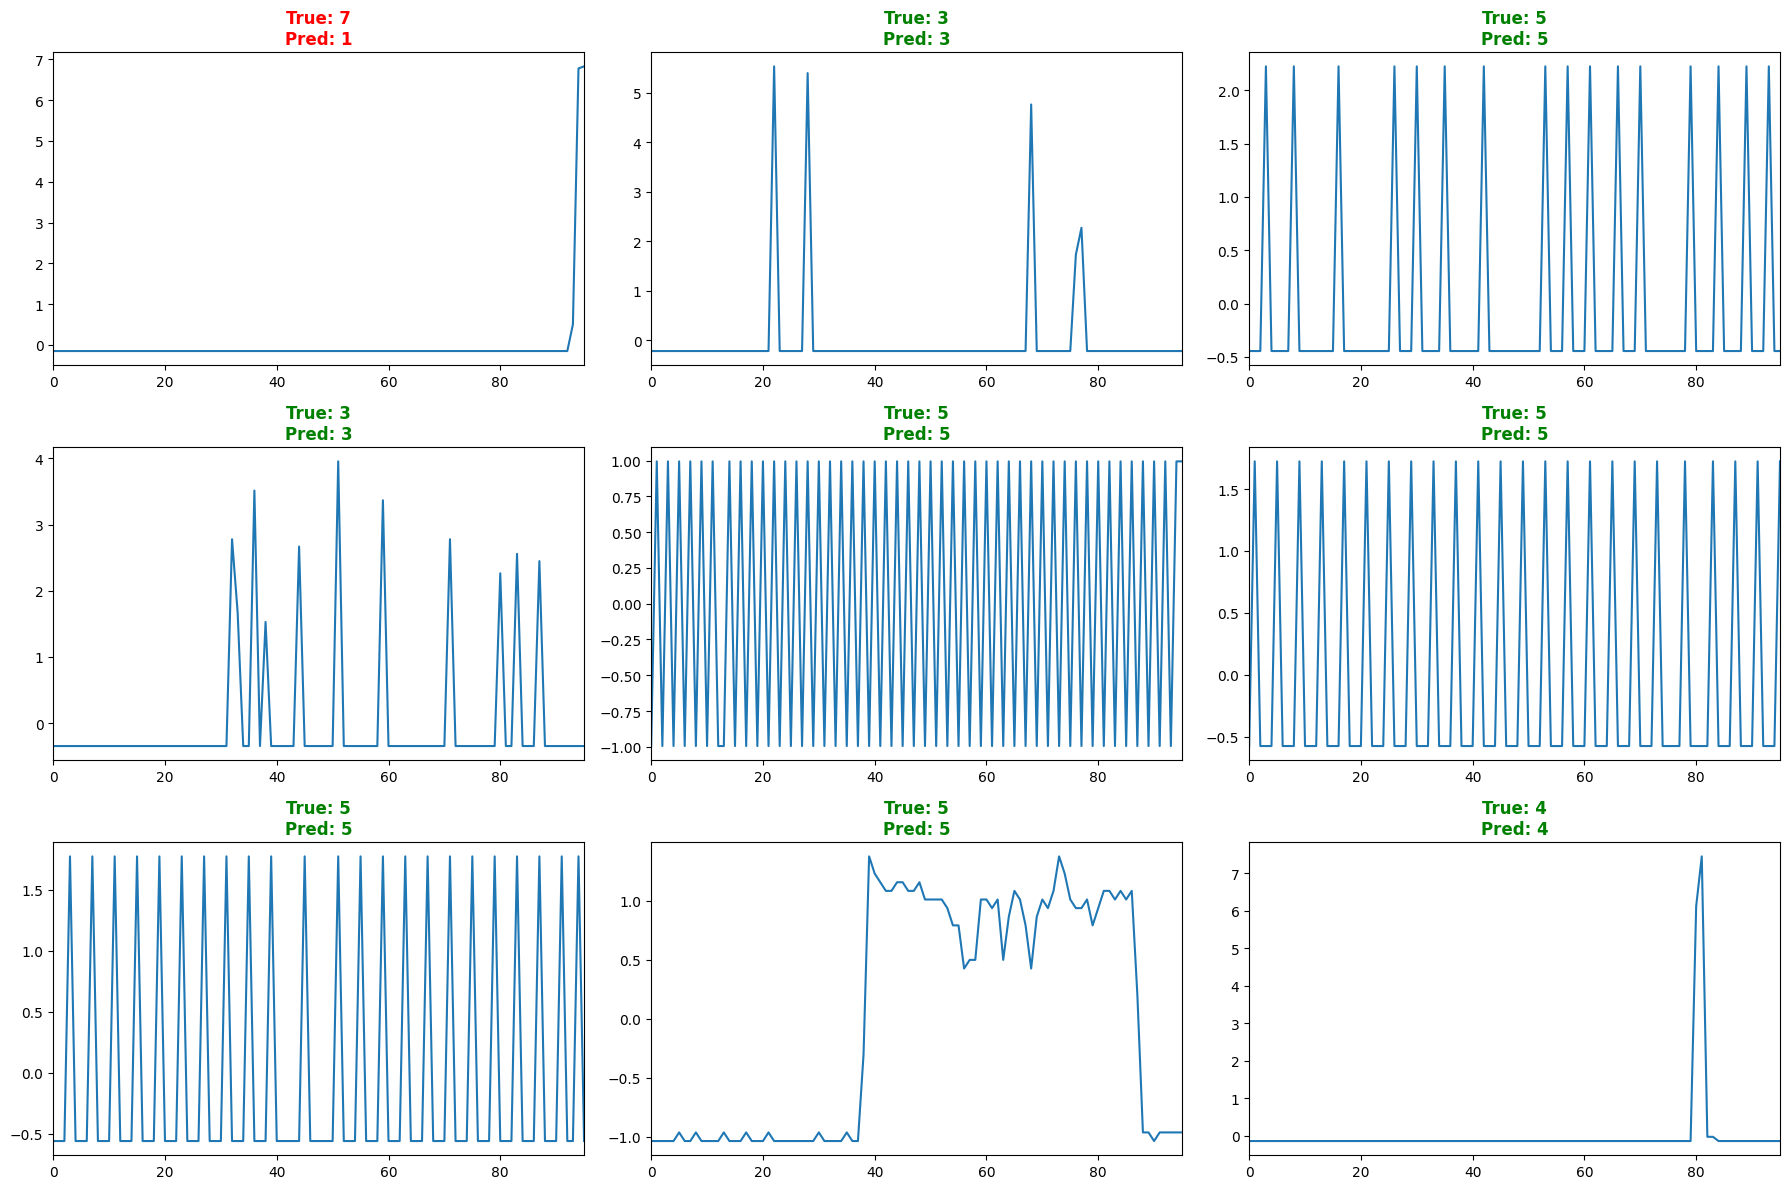

In [40]:
learn.show_results()

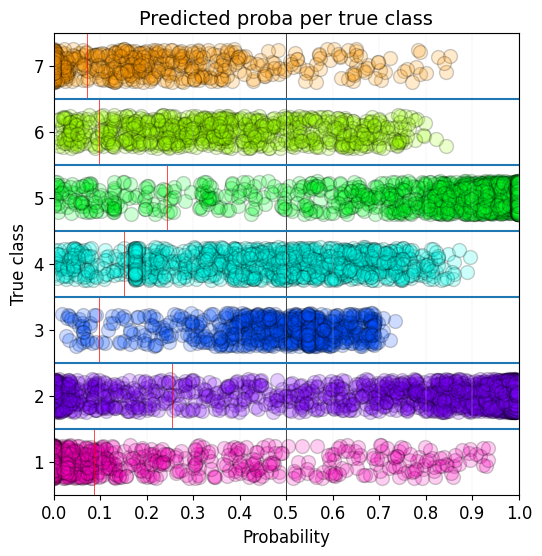

In [37]:
learn.show_probas()

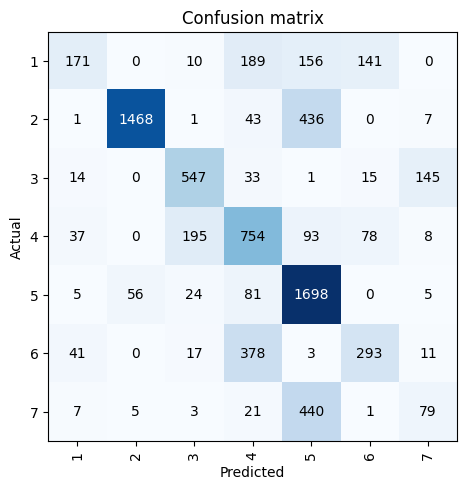

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused(min_val=3)

[('2.0', '3.0', 8), ('3.0', '2.0', 4)]

## Inference on additional data 🆕

Let's say we want to predict labels on new data. Let's see how this works.

We may have additional data (test set) where we want to check our performance. In this case, we'd add a labelled dataset:

In [ ]:
# Labelled test data
test_ds = valid_dl.dataset.add_test(X, y)# In this case I'll use X and y, but this would be your test data
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:128, vars:24, len:51, device=cuda:0, dtype=torch.float32),
 TensorCategory([3, 2, 2, 3, 2, 4, 0, 5, 2, 1, 5, 0, 3, 5, 2, 1, 2, 1, 1, 5, 3,
                 2, 4, 3, 0, 5, 2, 4, 4, 4, 2, 4, 2, 4, 3, 4, 2, 0, 3, 5, 2, 3,
                 3, 5, 0, 5, 1, 0, 0, 5, 3, 0, 2, 2, 1, 0, 4, 0, 1, 4, 3, 4, 1,
                 4, 0, 5, 2, 0, 1, 0, 2, 3, 3, 2, 4, 1, 1, 2, 2, 5, 5, 0, 1, 4,
                 1, 1, 3, 4, 5, 3, 1, 2, 0, 2, 0, 4, 5, 5, 4, 4, 5, 3, 1, 0, 1,
                 1, 1, 5, 4, 3, 2, 3, 0, 2, 4, 4, 4, 3, 2, 5, 2, 0, 2, 3, 0, 5,
                 1, 0], device='cuda:0'))

By selecting the valid dataset (valid_dl.dataset) we ensure that the same tfms applied to the valid data will be applied to the new data.

In [ ]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(TensorBase([[0.0033, 0.0049, 0.0082, 0.9645, 0.0076, 0.0116],
             [0.0038, 0.0470, 0.9334, 0.0045, 0.0087, 0.0026],
             [0.0069, 0.0981, 0.8684, 0.0075, 0.0147, 0.0044],
             ...,
             [0.0051, 0.0049, 0.0044, 0.0108, 0.9674, 0.0075],
             [0.0045, 0.0084, 0.0135, 0.9502, 0.0102, 0.0131],
             [0.0028, 0.0041, 0.0084, 0.9323, 0.0449, 0.0075]]),
 tensor([3, 2, 2, 3, 2, 4, 0, 5, 2, 1, 5, 0, 3, 5, 2, 1, 2, 1, 1, 5, 3, 2, 4, 3,
         0, 5, 2, 4, 4, 4, 2, 4, 2, 4, 3, 4, 2, 0, 3, 5, 2, 3, 3, 5, 0, 5, 1, 0,
         0, 5, 3, 0, 2, 2, 1, 0, 4, 0, 1, 4, 3, 4, 1, 4, 0, 5, 2, 0, 1, 0, 2, 3,
         3, 2, 4, 1, 1, 2, 2, 5, 5, 0, 1, 4, 1, 1, 3, 4, 5, 3, 1, 2, 0, 2, 0, 4,
         5, 5, 4, 4, 5, 3, 1, 0, 1, 1, 1, 5, 4, 3, 2, 3, 0, 2, 4, 4, 4, 3, 2, 5,
         2, 0, 2, 3, 0, 5, 1, 0, 5, 3, 0, 1, 4, 5, 5, 0, 5, 3, 5, 1, 0, 0, 0, 3,
         0, 5, 5, 2, 1, 5, 5, 2, 4, 4, 0, 1, 1, 4, 1, 2, 2, 4, 1, 3, 5, 3, 4, 1,
         1, 4, 3, 0, 5, 1, 3, 3, 4,

In [ ]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')

accuracy:   0.958333


If data is unlabelled, we'd just do this:

In [ ]:
# Unlabelled data
test_ds = dls.dataset.add_test(X)
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))

(TSTensor(samples:128, vars:24, len:51, device=cuda:0, dtype=torch.float32),)

In [ ]:
test_probas, *_ = learn.get_preds(dl=test_dl, save_preds=None)
test_probas

TensorBase([[0.0033, 0.0049, 0.0082, 0.9645, 0.0076, 0.0116],
            [0.0038, 0.0470, 0.9334, 0.0045, 0.0087, 0.0026],
            [0.0069, 0.0981, 0.8684, 0.0075, 0.0147, 0.0044],
            ...,
            [0.0051, 0.0049, 0.0044, 0.0108, 0.9674, 0.0075],
            [0.0045, 0.0084, 0.0135, 0.9502, 0.0102, 0.0131],
            [0.0028, 0.0041, 0.0084, 0.9323, 0.0449, 0.0075]])

## Summary ✅

This is all the code you need to train a TS model. As you can see, it's v2 is easier to use and faster compared to v1.

epoch,train_loss,valid_loss,accuracy,time
0,1.812071,1.791838,0.200000,00:00
1,1.703241,1.786025,0.222222,00:00
2,1.549177,1.776202,0.250000,00:00
3,1.382053,1.758431,0.300000,00:00
4,1.224261,1.724827,0.400000,00:00
5,1.090974,1.662398,0.455556,00:00
6,0.988261,1.559073,0.561111,00:00
7,0.898191,1.430685,0.594444,00:00
8,0.823266,1.263084,0.738889,00:00
9,0.758034,1.089732,0.783333,00:00


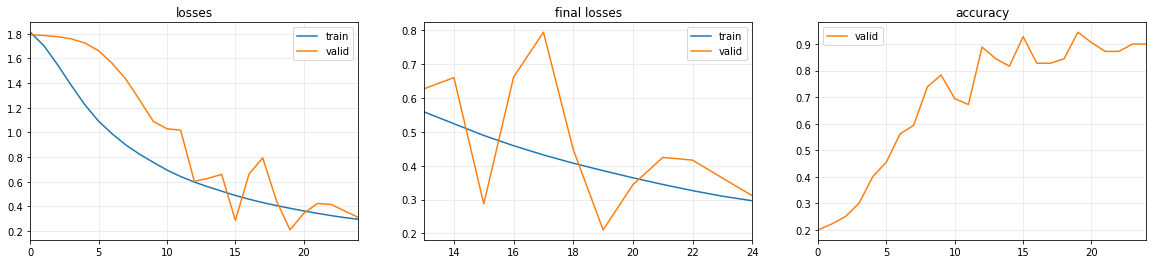

In [ ]:
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, return_split=False)
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.fit_one_cycle(25, lr_max=1e-3)
learn.plot_metrics()

## New scikit-learn-like API 🎉

As of `tsai` version 0.2.15 I have added a new scikit-learn-like API to further simplify the learner creation.

I will prepare a new tutorial to further demonstrate how you can use the new API.

This is how you can use it for Time Series Classification:

epoch,train_loss,valid_loss,accuracy,time
0,1.835447,1.800387,0.166667,00:00
1,1.737271,1.794084,0.166667,00:00
2,1.595897,1.783399,0.183333,00:00
3,1.430825,1.764957,0.283333,00:00
4,1.272314,1.731321,0.394444,00:00
5,1.140494,1.667722,0.433333,00:00
6,1.026725,1.565855,0.461111,00:00
7,0.930432,1.432250,0.611111,00:00
8,0.849818,1.263506,0.733333,00:00
9,0.778536,1.112045,0.755556,00:00


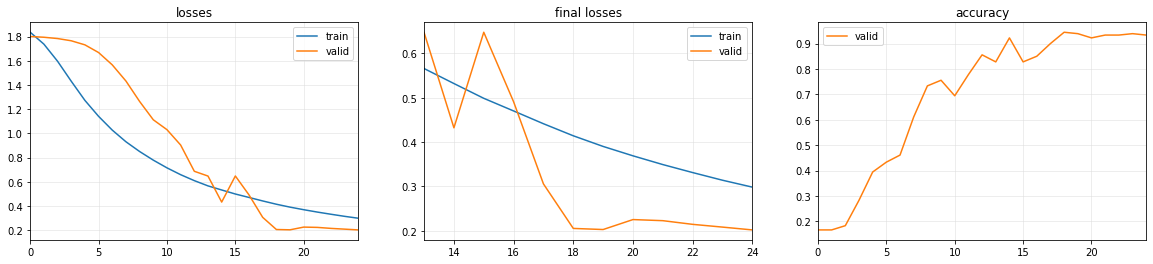

In [ ]:
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, return_split=False)
learn = TSClassifier(X, y, splits=splits, bs=[64, 128], batch_tfms=[TSStandardize()], arch=InceptionTime, metrics=accuracy)
learn.fit_one_cycle(25, lr_max=1e-3)
learn.plot_metrics()